In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym
env = gym.make("FiveElementResetFree-v0")
all_paths = ['../recordings/final_5element_hardware_Jun3_0.pkl', 
         '../recordings/final_5element_hardware_Jun3_1.pkl', 
         '../recordings/final_5element_hardware_Jun3_2.pkl', 
         '../recordings/final_5element_hardware_Jun3_3.pkl', 
         '../recordings/final_5element_hardware_Jun3_4.pkl', 
         '../recordings/final_5element_hardware_Jun3_5.pkl', 
         '../recordings/final_5element_hardware_Jun3_6.pkl', 
         '../recordings/final_5element_hardware_Jun3_7.pkl', 
         '../recordings/final_5element_hardware_Jun3_8.pkl',
         '../recordings/final_5element_hardware_Jun3_9.pkl',
         '../recordings/final_5element_hardware_Jun3_10.pkl']

dat = []

for p in all_paths:
    dat_curr = pickle.load(open(p, 'rb'))
    dat += dat_curr
print(len(dat))


GRAPH SEARCH IS False
Launching Timeslicer
 [     ] : Replacing old SSH connection          [■    ] : New SSH Established         [■■   ] : Killed old timeslicers          [■■■  ] : Started timeslicer spinup         [■■■■ ] : Timeslicer successfully started         [■■■■■] : Timeslicer launched with no errors          
***ROBOT ENABLED***
787


In [2]:
list_awac = och_2_awac(dat)
print(list_awac[0]['observations'].shape)
print(env.get_obs_dict())

(76, 26)
OrderedDict([('gripper_width', array([0.])), ('dynamixel_pos', array([4.4224668 , 1.3667768 , 3.8825054 , 3.2090878 , 0.08590292],
      dtype=float32)), ('ee_pos', array([0.18253098, 0.32928343, 1.01805837])), ('ee_quat', array([-0.26956568,  0.65101607, -0.27017152,  0.65614006])), ('goal', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))])


(76, 26)


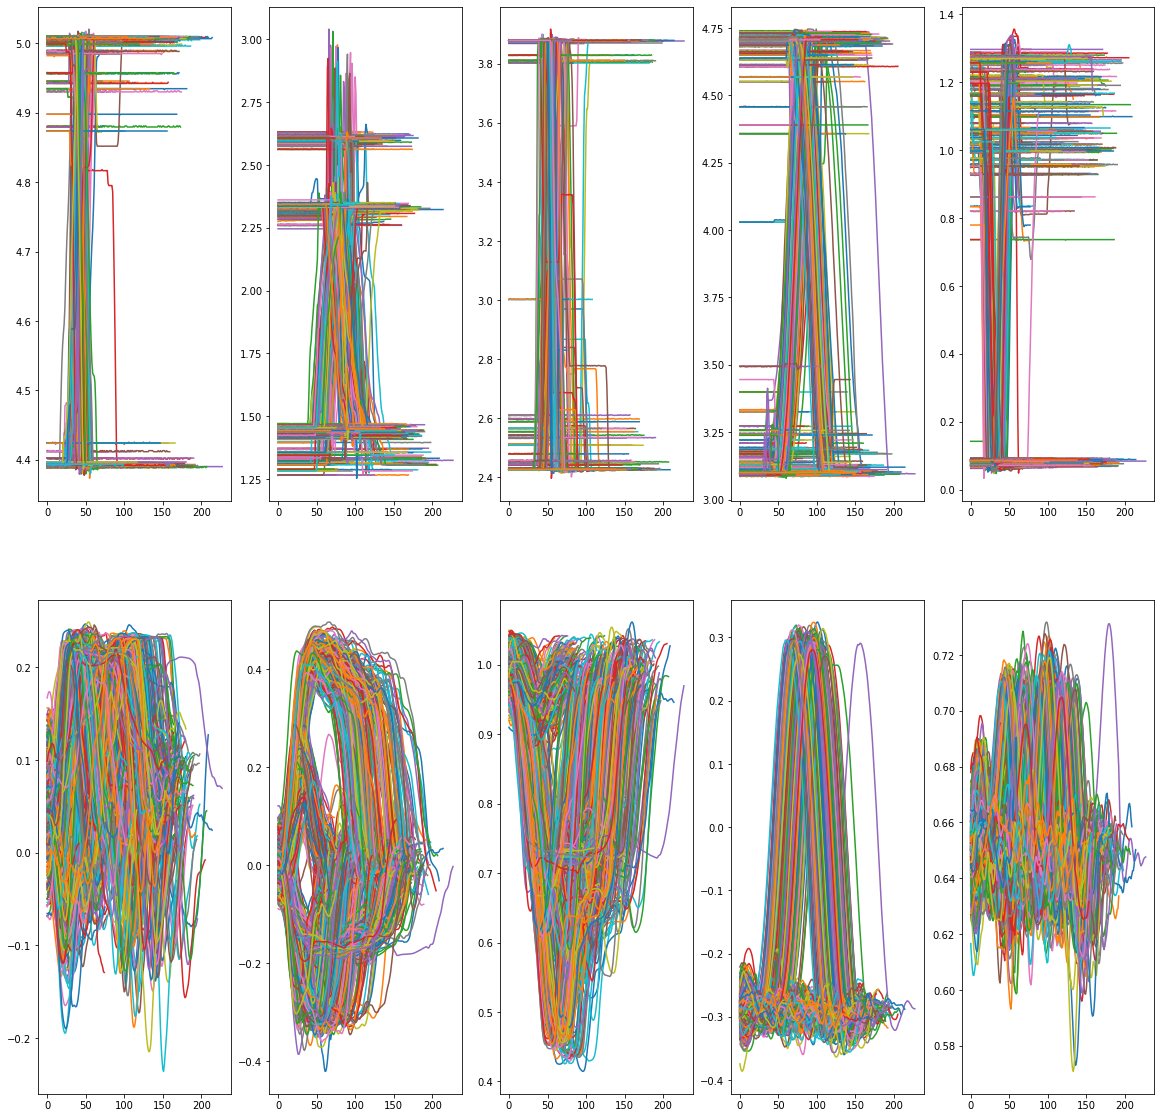

In [3]:
list_awac = och_2_awac(dat)
print(list_awac[0]['observations'].shape)
curr_x = 0
fig, ax = plt.subplots(2, 5, figsize=(20, 20))
for p in list_awac:
    for i in range(2):  
        for j in range(5):
            ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])

plt.show()

Broken IDX
Broken IDX
Broken IDX
Broken IDX
Broken IDX
Broken IDX


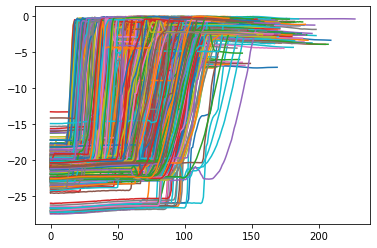

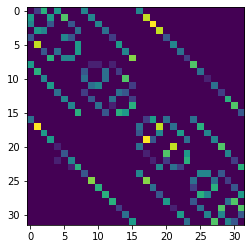

In [4]:
import itertools

def check_goal_completion(curr_pos):
    broken = False
    max_objs = np.array([4.8, 2.2, 3.7, 4.25, 0.7])
    min_objs = np.array([4.5, 1.5, 2.65, 3.5, 0.2])
    init_bitflips = np.array([0, 0, 0, 0, 0])
    curr_bitflips = init_bitflips.copy()
    if len(curr_pos.shape) > 1:
        curr_pos = curr_pos.squeeze(axis=0)
    for j in range(5):
        if curr_pos[j] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[j] < min_objs[j]:
            curr_bitflips[j] = 0
        else:
            broken = True
    mult = np.array([2**i for i in range(5)])[::-1]
    new_idx = np.sum(mult*curr_bitflips)
    return new_idx, broken


good_paths = []
broken_idxs = []
for i, p in enumerate(list_awac):
    _, b = check_goal_completion(p['observations'][0, 0:5])
    _, b2 = check_goal_completion(p['observations'][-1, 0:5])
    if b or b2:
        print("Broken IDX")
        broken_idxs.append(i)
        continue
    good_paths.append(p)

list_awac = good_paths

idx_completion = False
def end_relabel(env, path):
    o_size = 13
    
    path['observations'] = path['observations'][:, :o_size]
    path['next_observations'] = path['next_observations'][:, :o_size]
    
    goal_idx, _ = check_goal_completion(path['observations'][-1, 0:5])
    concat_val = np.zeros((path['observations'].shape[0], 32))
    concat_val[:, goal_idx] = 1.
#     concat_val = np.repeat([path['observations'][-1, :o_size]], path['observations'].shape[0], axis=0)
    path['observations'] = np.concatenate([path['observations'], concat_val.copy()], axis=-1)
    path['next_observations'] = np.concatenate([path['next_observations'], concat_val.copy()], axis=-1)
    
    env.env.goal_idx, _ = check_goal_completion(path['observations'][-1, 0:5])
    env.env.current_idx, _ = check_goal_completion(path['observations'][0, 0:5])
    env.env.goal = concat_val.copy()
    env.env._idx_completion = idx_completion
    path['rewards'] = np.zeros_like(path['rewards'])
    for idx in range(len(path['observations'])):
        reward_dict = env.env.get_reward_dict(None, {'dynamixel_pos': path['observations'][idx:idx+1, 0:5],
                                                     'ee_pos': path['observations'][idx:idx+1, 5:8]})
        path['rewards'][idx] = np.sum([v for k, v in reward_dict.items()])
    return path


import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt 
curr_x = 0  
label_list = itertools.product(['SC', 'SO'], ['ToC', 'ToO'], ['SwC', 'SwO'], ['KC', 'KO'], ['CC', 'CO'])
tasks = ['-'.join(s) for s in label_list]
# tasks = ['CC', 'CO', 'OC', 'OO']
task_list = []
adjacency_matrix = np.zeros((32, 32))
labeled_goals = [[] for _ in range(32)]
counts_starts = np.zeros(32)
counts_goals = np.zeros(32)
end_states = [None for _ in range(32)]
end_states_val = [None for _ in range(32)]
path_lists = [[[] for _ in range(32)] for _ in range(32)]
filtered_paths = []
for i, path in enumerate(list_awac):
    start_idx, _ = check_goal_completion(path['observations'][0, 0:5])
    end_idx, _ = check_goal_completion(path['observations'][-1, 0:5])
    if start_idx == end_idx:
        print("FOUND A BROKEN DEMO")
        continue
    end_relabel(env, path)
    plt.plot(path['rewards'])
    filtered_paths.append(path)
plt.show()
    
for p in filtered_paths:
    curr_x += len(p['observations'])
    start_idx, _ = check_goal_completion(p['observations'][0, 0:5])
    start = tasks[start_idx]
    end_idx, _ = check_goal_completion(p['observations'][-1, 0:5])
    if start_idx == end_idx:
        print("FOUND A BROKEN DEMO")
        continue
    end = tasks[end_idx]
    adjacency_matrix[start_idx, end_idx] += 1
    path_lists[start_idx][end_idx].append(copy.deepcopy(p))
    task_list.append(check_goal_completion(p['observations'][-1, 0:5])[0])
    labeled_goals[end_idx].append(p['observations'][-1])
    counts_goals[end_idx] += 1
    counts_starts[start_idx] += 1
    if end_states[end_idx] is None:
        end_states_val[end_idx] = p['observations'][-1, :13]
        ei_val = np.zeros(32)
        ei_val[end_idx] = 1.
        end_states[end_idx] = ei_val.copy() #p['observations'][-1, :15]
#         end_states[end_idx] = p['observations'][-1, :13]
plt.show() 

# goal matrix generation
goal_matrix = np.zeros((32, 32))
for i in range(32):
    for j in range(32):
        if adjacency_matrix[i, j] > 0:
            goal_matrix[i, j] = 1
            
plt.imshow(adjacency_matrix)
plt.show()

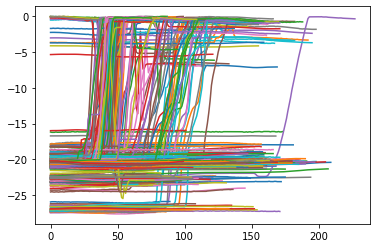

In [5]:
import copy

idx_completion = False
def end_relabel(env, path):
    o_size = 13
    
    path['observations'] = path['observations'][:, :o_size]
    path['next_observations'] = path['next_observations'][:, :o_size]
    
    goal_idx, _ = check_goal_completion(path['observations'][-1, 0:5])
    concat_val = np.zeros((path['observations'].shape[0], 32))
    rand_idx = np.random.randint(32)
    while rand_idx == goal_idx:
        rand_idx = np.random.randint(32)
    goal_idx = rand_idx
    concat_val[:, goal_idx] = 1.
    path['observations'] = np.concatenate([path['observations'], concat_val.copy()], axis=-1)
    path['next_observations'] = np.concatenate([path['next_observations'], concat_val.copy()], axis=-1)
    
    env.env.goal_idx = goal_idx #check_goal_completion(path['observations'][-1, 0:5])
    env.env.current_idx, _ = check_goal_completion(path['observations'][0, 0:5])
    env.env.goal = concat_val.copy()
    env.env._idx_completion = idx_completion
    path['rewards'] = np.zeros_like(path['rewards'])
    for idx in range(len(path['observations'])):
        reward_dict = env.env.get_reward_dict(None, {'dynamixel_pos': path['observations'][idx:idx+1, 0:5],
                                                     'ee_pos': path['observations'][idx:idx+1, 5:8]})
        path['rewards'][idx] = np.sum([v for k, v in reward_dict.items()])
    return path

negative_paths = []
for i, path in enumerate(filtered_paths):
    new_path = copy.deepcopy(path)
    new_path = end_relabel(env, new_path)
    plt.plot(new_path['rewards'])
    negative_paths.append(new_path)
plt.show()

In [ ]:
combined_list = []
for j in [1,2,4,16]:
    for p in path_lists[0][j]:
        combined_list.append(p)
print(len(combined_list))
pickle.dump(combined_list, open('0start_combined_list_5elementhardware.pkl', 'wb'))

In [6]:
pickle.dump(filtered_paths, open('demo_list_hardware_5elements_dense_fixedbug.pkl', 'wb'))

In [7]:
pickle.dump(adjacency_matrix, open('adjacency_matrix_hardware_5elements.pkl', 'wb'))

In [8]:
pickle.dump(goal_matrix, open('5elements_goalmatrix_hardware.pkl', 'wb'))

In [9]:
pickle.dump(end_states, open('end_states_5elements_hardware.pkl', 'wb'))

In [10]:
pickle.dump(end_states_val, open('end_states_val_5elements_hardware.pkl', 'wb'))